# Callbacks

`Callbacks`是指模型在訓練過程中加入的訓練策略，常用的 `Callbacks` 有:

* `Early stopping`: 在 `overfitting` 發生之前提早停止訓練。

* `ModelCheckpoint`: 在訓練過程中決定何時儲存模型，例如當測試集的 loss 降到最低點時儲存模型。

* `LearningRateScheduler`: 動態調整學習率，例如在前 10 個 `epochs` 將學習率慢慢調大，之後慢慢調小。


# 載入函數

In [ ]:
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
# torch api
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchsummary import summary
# device add gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")       # 使用Nvidia 顯卡

## 準備資料

In [ ]:
def linear_model(rseed=222, n_samples=30):
    " Generate data according to a linear model"
    np.random.seed(rseed)

    data = np.float32(np.random.normal(-1, 1, (n_samples, 2)))
    data[:n_samples // 2] -= 1.5
    data[n_samples // 2:] += 1.5

    labels = np.ones(n_samples, dtype = 'int64')
    labels[:n_samples // 2] = 0

    return data, labels

## 產生資料集

In [ ]:
n_samples = 2000
X, y = linear_model(n_samples = n_samples)
print(X.shape, y.shape)
print(X.dtype, y.dtype)

(2000, 2) (2000,)
float32 int64


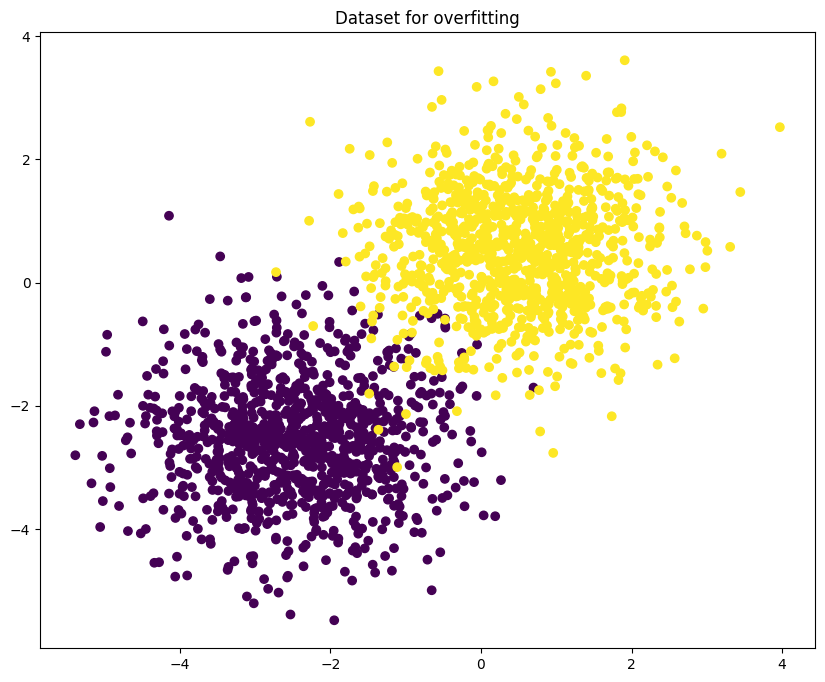

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], c = y)
plt.title('Dataset for overfitting')
plt.show()

## 切割訓練集 (Training set) 以及測試集 (testing set)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)

print('Training data size: ', X_train.shape)
print('Testing data size: ', X_test.shape)

Training data size:  (1200, 2)
Testing data size:  (800, 2)


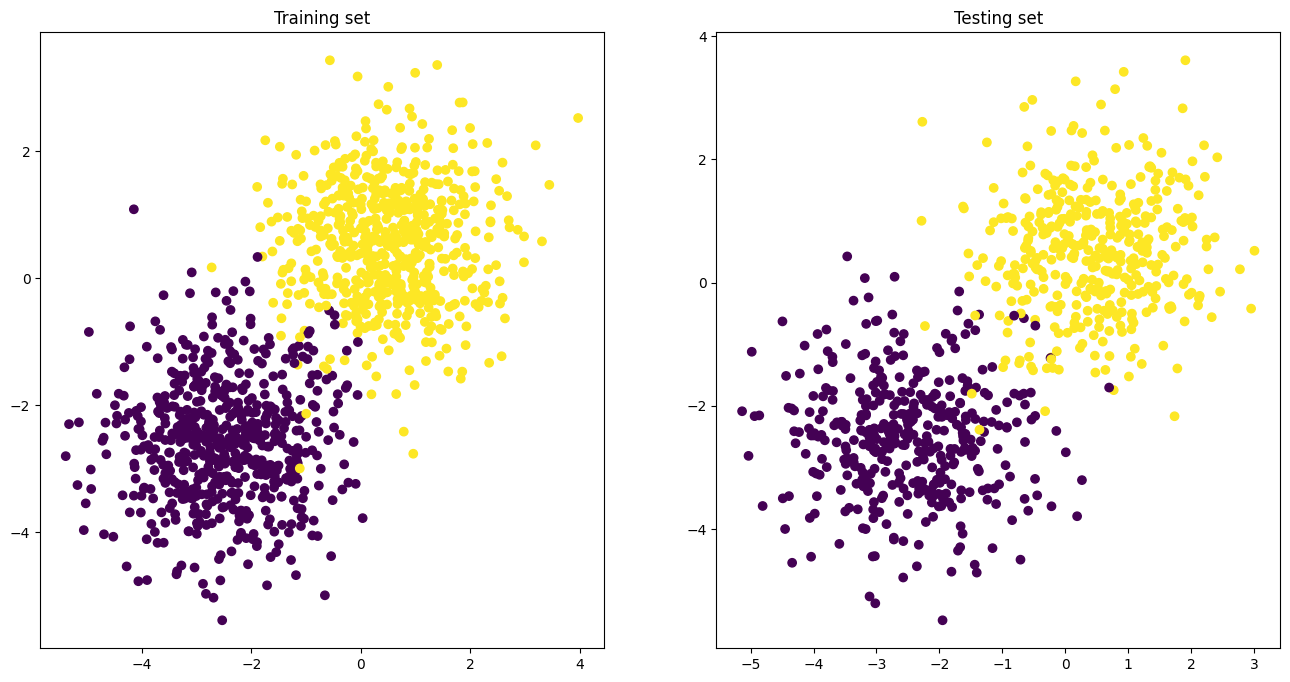

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.scatter(X_train[:,0], X_train[:,1], c = y_train)
plt.title('Training set')

plt.subplot(1,2,2)
plt.scatter(X_test[:,0], X_test[:,1], c = y_test)
plt.title('Testing set')
plt.show()

In [ ]:
## 建立訓練的generator(後續CNN課程會詳解)，簡單來說因為資料量可能會偏大，所以使用generator可以將所有資料分成n筆資料訓練一次。
class Custom_Generator(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data        # 輸入的訓練資料
        self.y_data = y_data        # 輸入訓練資料的標籤

    def __getitem__(self, index):
        data = self.X_data[index]
        target = self.y_data[index]

        return data,target

    def __len__(self):
        return len(self.X_data)     # 回傳資料集數量

In [ ]:
# 1. 先呼叫我們寫好的Custom_Generator
train_data  = Custom_Generator(X_data = X_train, y_data = y_train)

# 2. 呼叫pytorch的DataLoader來做批次動作，模型的輸入
trainloader = DataLoader(train_data, batch_size=32,shuffle=True)

# 1. 先呼叫我們寫好的Custom_Generator
test_data  = Custom_Generator(X_data = X_test, y_data = y_test)

# 2. 呼叫pytorch的DataLoader來做批次動作，模型的輸入
testloader = DataLoader(test_data, batch_size=32,shuffle=False)

## 建立模型

In [ ]:
class DNN(nn.Module):
    def __init__(self, input_shape, act = nn.ReLU(inplace=True)):
        super(DNN, self).__init__()
        self.fc = nn.Sequential(nn.Linear(in_features = input_shape, out_features = 32, bias = True),
                                act,
                                nn.Linear(in_features = 32, out_features = 64, bias = True),
                                act,
                                nn.Linear(in_features = 64, out_features = 128, bias = True),
                                act,
                                nn.Linear(in_features = 128, out_features = 64, bias = True),
                                act,)
        self.output = nn.Linear(in_features = 64, out_features = 2, bias = True)

    def forward(self,x):

        return self.output(self.fc(x))

In [ ]:
model = DNN(input_shape = 2).to(device)
print(model)
summary(model, input_size = (2,))

DNN(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(inplace=True)
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]              96
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 64]           2,112
              ReLU-4                   [-1, 64]               0
            Linear-5                  [-1, 128]           8,320
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-

In [ ]:
# 設定loss function
criterion = nn.CrossEntropyLoss()
# learning rate
learning_rate = 0.01
# epochs數量
epochs = 50
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

## ModelCheckpoint

In [ ]:
import os

folder = 'save_model'
if not os.path.exists(folder):
    os.mkdir(folder)

model_path = './save_model/checkpoints_model.pth'  # 模型儲存的位置

## LearningRateDecay : ReduceLROnPlateau
隨著訓練過程去調整學習率，可以依照我們監控的loss來去動態調整學習率，所以要用 scheduler.step(test_loss/len(testloader))

In [ ]:
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                                                        mode='min',
#                                                        factor=0.1,
#                                                        patience=3,
#                                                        verbose=True)


## LearningRateDecay : Cosine Decay Schedule
隨著訓練過程去調整學習率，可以依照 epoch 動態調整學習率，所以要用 scheduler.step()

In [ ]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max=epochs,
                                                       verbose=True)

# θ=0 到 θ=π

## 訓練模型

In [ ]:
def Train_Process(model, epochs, optimizer, criterion, l1_rate, trainloader, testloader, model_path):
    Train_loss = []
    Train_acc = []
    valid_loss = []
    valid_acc = []
    lr_rate = []
    Best_acc = 0
    # 第1步驟
    for epoch in range(epochs):
        # 訓練階段
        model.train()
        running_loss = 0.0  # 訓練時的loss
        accuracy = 0.0
        total = 0.0
        # 第2步驟
        for times, data_train in enumerate(trainloader, 0):  # data_train會包括訓練的資料以及訓練的標籤
            # batch data input
            inputs, labels = data_train
            inputs, labels = inputs.to(device), labels.to(device)
            # 第3步驟
            # Zero the parameter gradients
            optimizer.zero_grad()

            # model Feedforward
            output_train = model(inputs)

            # 第4步驟
            # Feed forward loss result
            loss = criterion(output_train, labels)
            ################################
            # L1 regularization
            regularization_loss = 0.0
            for param in model.parameters():
                regularization_loss += torch.sum(torch.abs(param))
            loss = loss + l1_rate * regularization_loss
            ###############################
            # 第5步驟
            # backward update
            loss.backward()

            # 第6步驟
            # optimize
            optimizer.step()

            # 將每一筆資料的loss都加起來，假設有100筆資料就會有100個loss的結果
            # Compute loss
            running_loss += loss.item()

            # Compute Accuracy
            _, predicted = torch.max(output_train.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

            # 當一個epoch結束後，顯示結果
            if times+1 == len(trainloader):
                print('[%d/%d, %d/%d] loss: %.3f, acc: %.3f,' % (epoch+1,
                                                                 epochs,
                                                                 times+1,
                                                                 len(trainloader),
                                                                 running_loss/len(trainloader),
                                                                 accuracy / total),end = " ")
                Train_loss.append(running_loss/len(trainloader))
                Train_acc.append(accuracy / total)
        # 測試階段
        model.eval()
        test_loss = 0.0
        test_accuracy = 0.0
        total = 0.0

        with torch.no_grad(): # disable gradient calculation for efficiency
            for times, data_test in enumerate(testloader, 0):
                # batch data input
                inputs, labels = data_test
                inputs, labels = inputs.to(device), labels.to(device)

                # model predict
                output_test = model(inputs)

                # Compute loss
                loss_t = criterion(output_test, labels)
                test_loss += loss_t.item()

                # Compute accuracy
                _, predicted = torch.max(output_test.data, 1)
                total += labels.size(0)
                test_accuracy += (predicted == labels).sum().item()

                if times+1 == len(testloader):
                    # 加入learning rate function
                    scheduler.step()
                    current_lr = optimizer.param_groups[0]['lr']
                    lr_rate.append(current_lr)

                    print('test_loss: %.3f, test_acc: %.3f, current Learning Rate: %.3f' % (test_loss / len(testloader),
                                                                                            test_accuracy / total,
                                                                                             current_lr))

                    if (test_accuracy / total) > Best_acc:
                        Best_acc = (test_accuracy / total)
                        torch.save(model, model_path)
                        print("Save model!")

                    valid_loss.append(test_loss / len(testloader))
                    valid_acc.append(test_accuracy / total)

    return Train_loss, Train_acc, valid_loss, valid_acc, lr_rate

In [ ]:
Train_loss, Train_acc, valid_loss, valid_acc, lr_rate = Train_Process(model = model,
                                                             epochs = epochs,
                                                             optimizer = optimizer,
                                                             criterion = criterion,
                                                             l1_rate = 0.0,
                                                             trainloader = trainloader,
                                                             testloader = testloader,
                                                             model_path = model_path)

[1/50, 38/38] loss: 0.635, acc: 0.848, test_loss: 0.487, test_acc: 0.983, current Learning Rate: 0.010
Save model!
[2/50, 38/38] loss: 0.185, acc: 0.981, test_loss: 0.062, test_acc: 0.976, current Learning Rate: 0.010
[3/50, 38/38] loss: 0.047, acc: 0.983, test_loss: 0.057, test_acc: 0.980, current Learning Rate: 0.010
[4/50, 38/38] loss: 0.048, acc: 0.982, test_loss: 0.057, test_acc: 0.978, current Learning Rate: 0.010
[5/50, 38/38] loss: 0.047, acc: 0.984, test_loss: 0.056, test_acc: 0.979, current Learning Rate: 0.010
[6/50, 38/38] loss: 0.044, acc: 0.984, test_loss: 0.057, test_acc: 0.980, current Learning Rate: 0.010
[7/50, 38/38] loss: 0.045, acc: 0.985, test_loss: 0.060, test_acc: 0.976, current Learning Rate: 0.010
[8/50, 38/38] loss: 0.046, acc: 0.983, test_loss: 0.057, test_acc: 0.980, current Learning Rate: 0.009
[9/50, 38/38] loss: 0.047, acc: 0.982, test_loss: 0.057, test_acc: 0.978, current Learning Rate: 0.009
[10/50, 38/38] loss: 0.045, acc: 0.983, test_loss: 0.057, tes

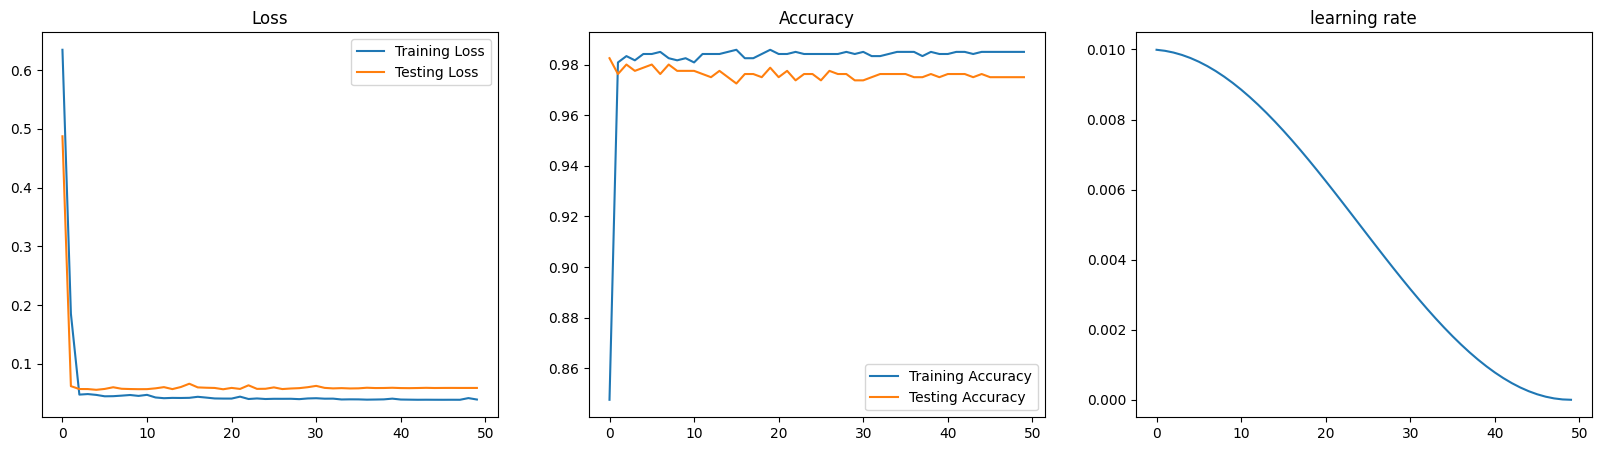

In [ ]:
# 視覺化訓練過程
plt.figure(figsize=(20, 5))

# 繪製 Training loss 和 Validation loss
plt.subplot(131)
plt.plot(range(len(Train_loss)), Train_loss, label='Training Loss')
plt.plot(range(len(valid_loss)), valid_loss, label='Testing Loss')
plt.legend(loc='best')
plt.title('Loss')

# 繪製 Training accuracy 和 Validation accuracy
plt.subplot(132)
plt.plot(range(len(Train_acc)), Train_acc, label='Training Accuracy')
plt.plot(range(len(valid_acc)), valid_acc, label='Testing Accuracy')
plt.legend(loc='best')
plt.title('Accuracy')

# 繪製 Training accuracy 和 Validation accuracy
plt.subplot(133)
plt.plot(range(len(lr_rate)), lr_rate, label='learning rate')
plt.title('learning rate')

plt.show()